## Iamgenes de los lagos Amatitlan y Atitlan por mes sacadas de Sentinel Hub

Conectando a openEO (modo rápido)…
Authenticated using refresh token.
Conectado.
Meses: ['2025-02', '2025-03', '2025-04', '2025-05', '2025-07', '2025-08']

=== Atitlan ===
Atitlan | 2025-02 | 2025-02-07


C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


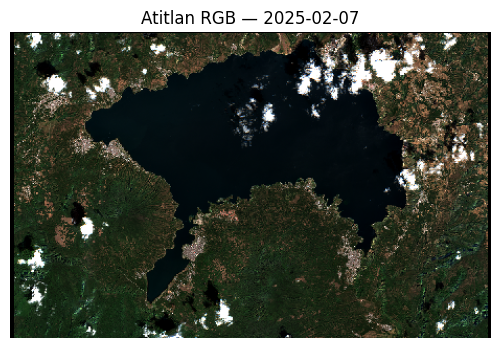

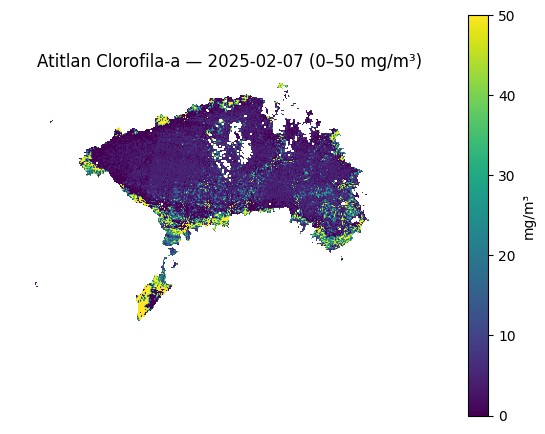

Atitlan | 2025-02 | 2025-02-27


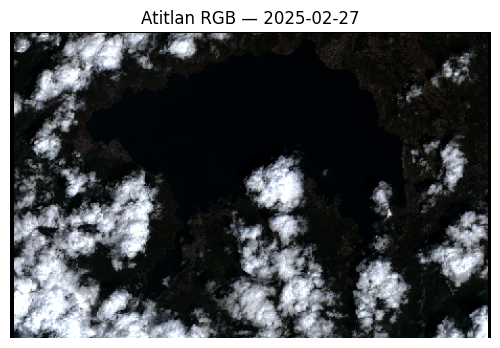

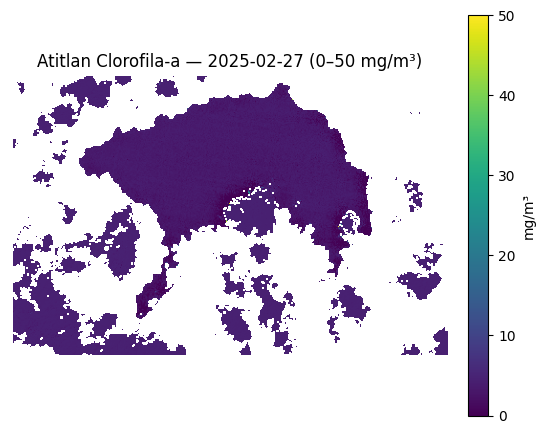

Atitlan | 2025-03 | 2025-03-02


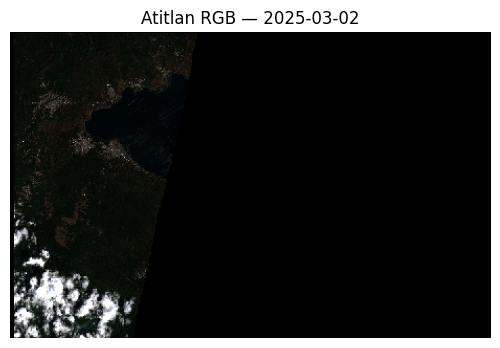

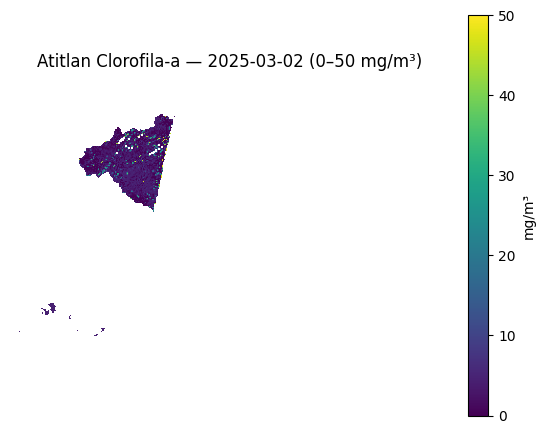

Atitlan | 2025-03 | 2025-03-26


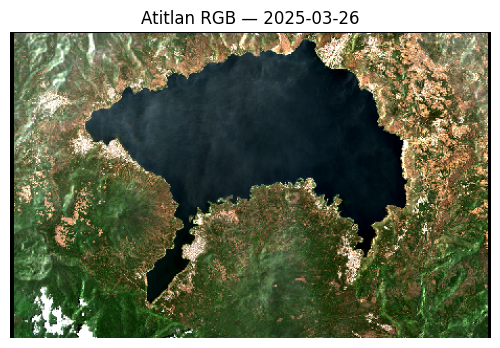

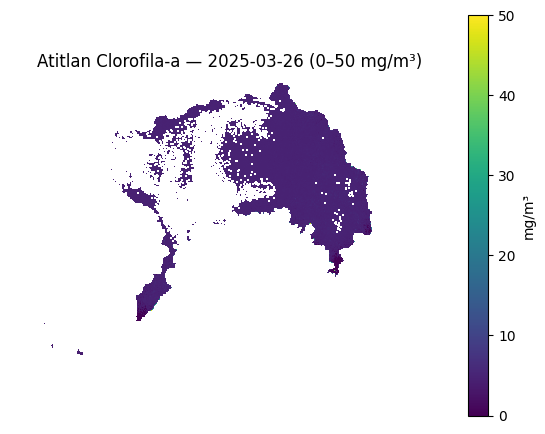

Atitlan | 2025-04 | 2025-04-03


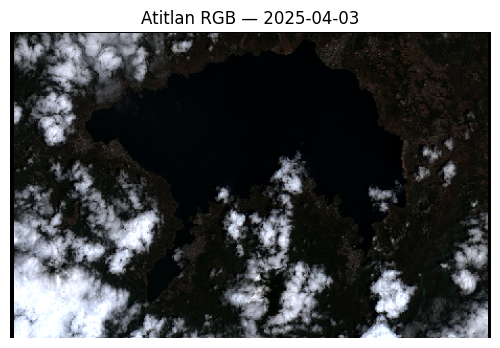

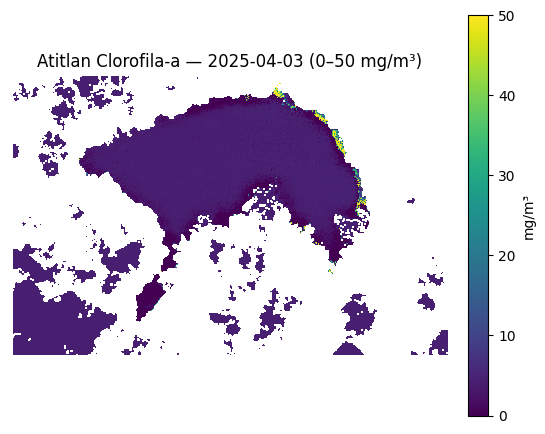

Atitlan | 2025-04 | 2025-04-28


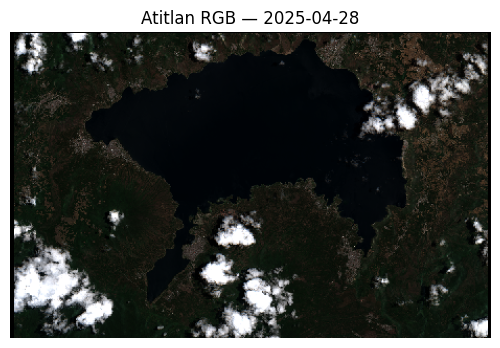

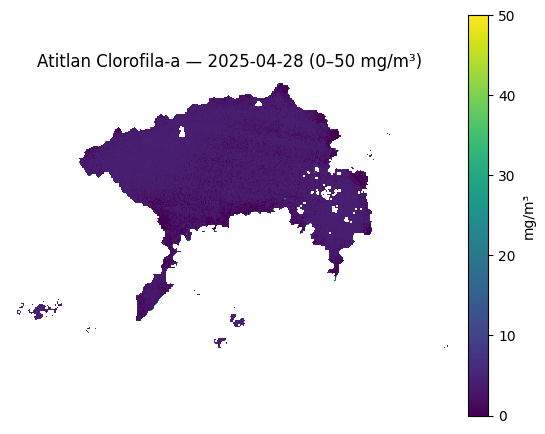

Atitlan | 2025-05 | 2025-05-03


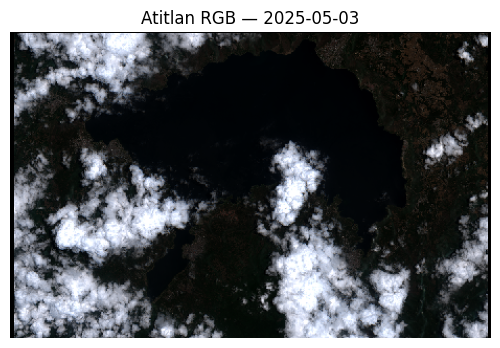

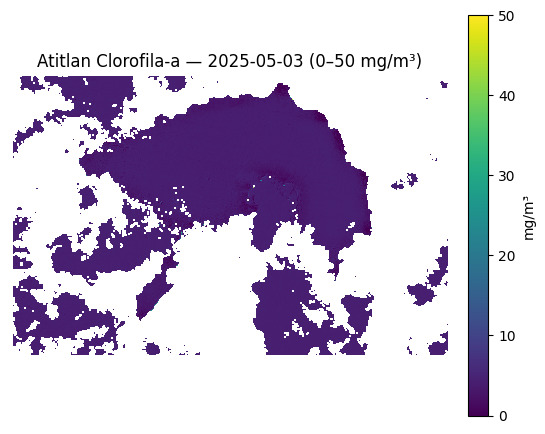

Atitlan | 2025-05 | 2025-05-28


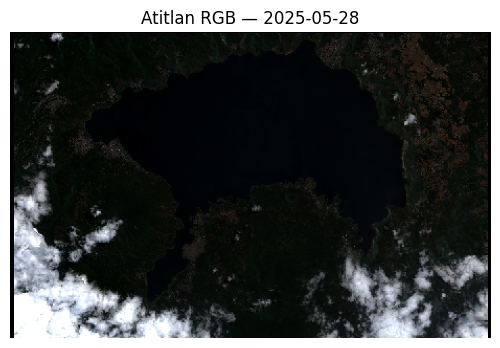

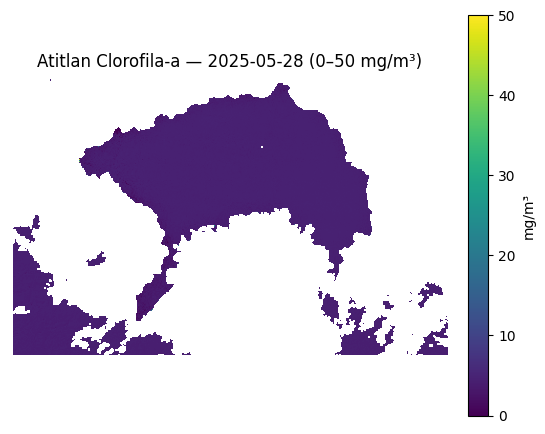

Atitlan | 2025-07 | 2025-07-10


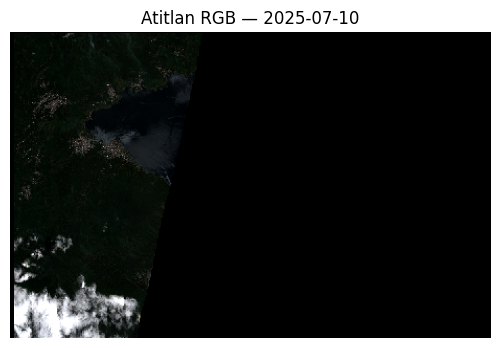

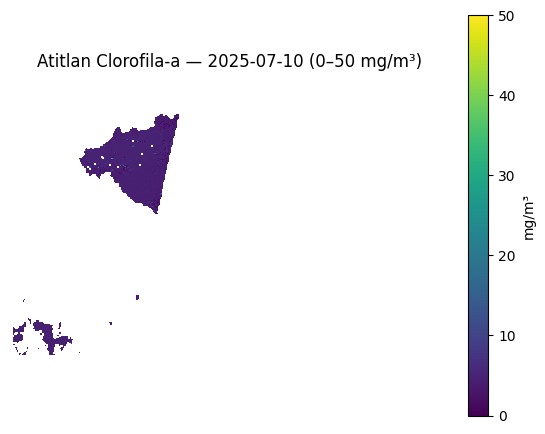

Atitlan | 2025-07 | 2025-07-24


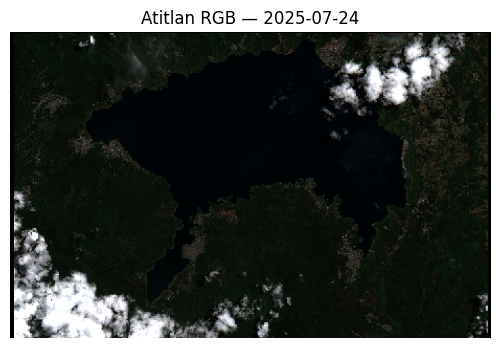

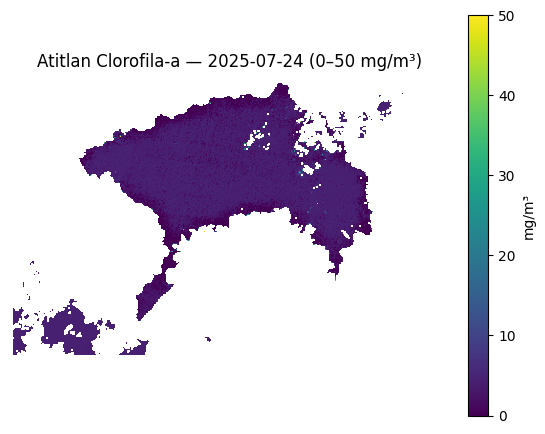

Atitlan | 2025-08 | 2025-08-01


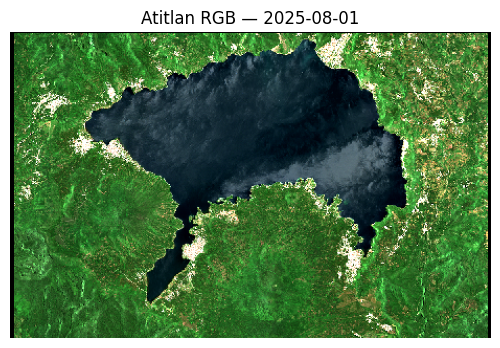

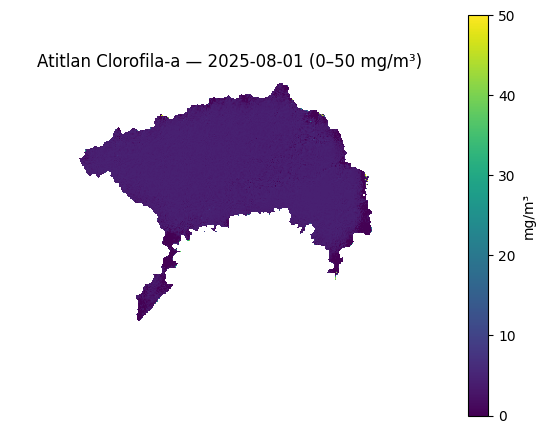


=== Amatitlan ===
Amatitlan | 2025-02 | 2025-02-07


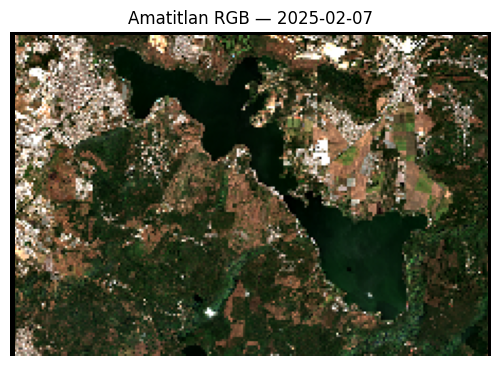

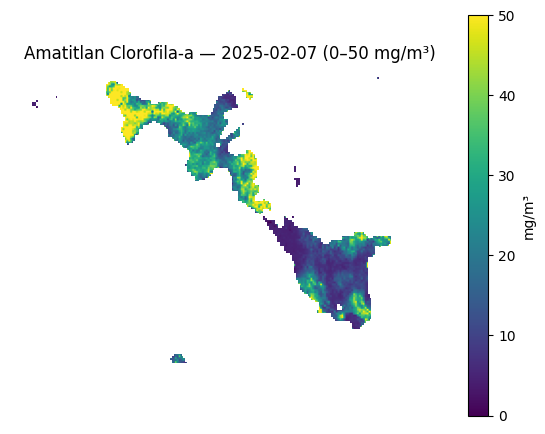

Amatitlan | 2025-02 | 2025-02-27


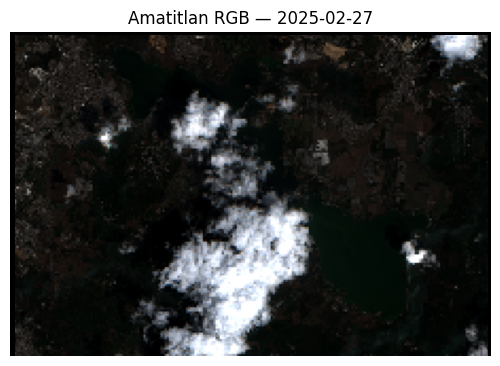

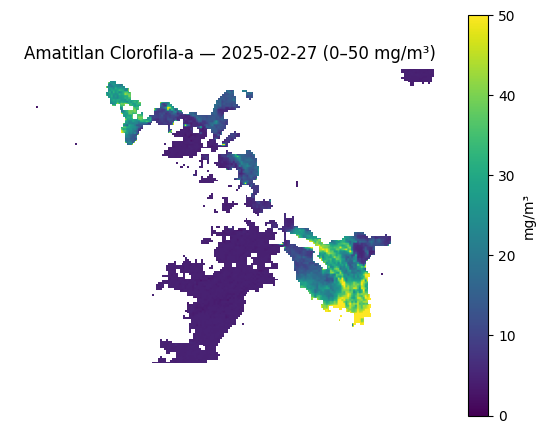

Amatitlan | 2025-03 | 2025-03-02
[WARN] Amatitlan 2025-03-02: [400] NoDataAvailable: There is no data available for the given extents. Could not find data for your load_collection request with catalog ID "Sentinel2". The catalog query had correlation ID "r-2508120321254c86858e603b7b596c61" and returned 0 results. (ref: r-2508120321254c86858e603b7b596c61)
Amatitlan | 2025-03 | 2025-03-26


Failed to parse API error response: [429] 'Too Many Requests' (headers: {'Retry-After': '3', 'X-Retry-In': '2.65306161s', 'Date': 'Tue, 12 Aug 2025 03:21:27 GMT', 'Content-Length': '17'})


[WARN] Amatitlan 2025-03-26: [429] Too Many Requests
Amatitlan | 2025-04 | 2025-04-03


Failed to parse API error response: [429] 'Too Many Requests' (headers: {'Retry-After': '2', 'X-Retry-In': '1.749125999s', 'Date': 'Tue, 12 Aug 2025 03:21:28 GMT', 'Content-Length': '17'})


[WARN] Amatitlan 2025-04-03: [429] Too Many Requests
Amatitlan | 2025-04 | 2025-04-28


Failed to parse API error response: [429] 'Too Many Requests' (headers: {'Retry-After': '1', 'X-Retry-In': '854.945005ms', 'Date': 'Tue, 12 Aug 2025 03:21:29 GMT', 'Content-Length': '17'})


[WARN] Amatitlan 2025-04-28: [429] Too Many Requests
Amatitlan | 2025-05 | 2025-05-03


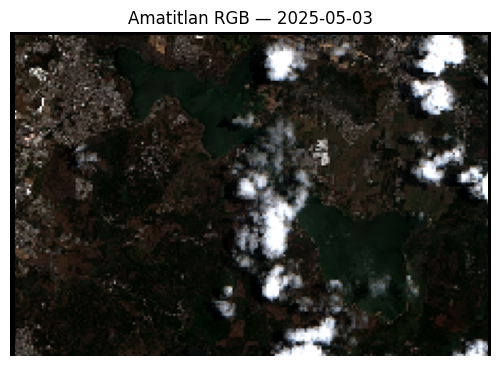

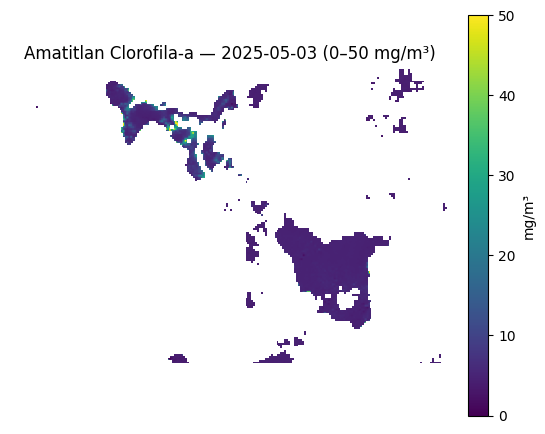

Amatitlan | 2025-05 | 2025-05-28


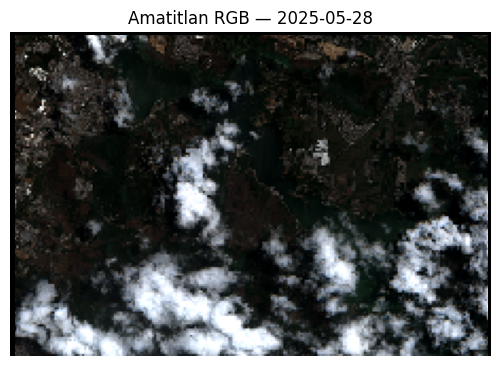

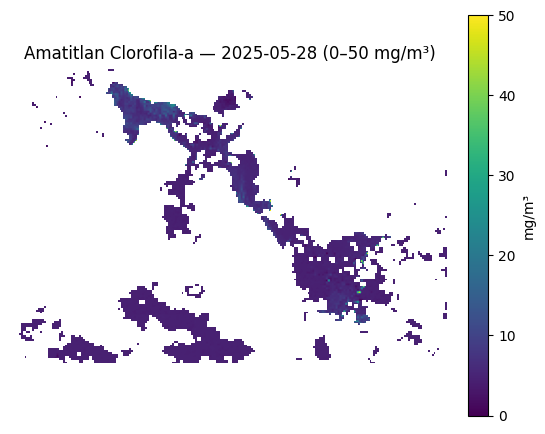

Amatitlan | 2025-07 | 2025-07-10
[WARN] Amatitlan 2025-07-10: [400] NoDataAvailable: There is no data available for the given extents. Could not find data for your load_collection request with catalog ID "Sentinel2". The catalog query had correlation ID "r-25081203222343dea0ca34d9d1841459" and returned 0 results. (ref: r-25081203222343dea0ca34d9d1841459)
Amatitlan | 2025-07 | 2025-07-24


Failed to parse API error response: [429] 'Too Many Requests' (headers: {'Retry-After': '4', 'X-Retry-In': '3.141804603s', 'Date': 'Tue, 12 Aug 2025 03:22:25 GMT', 'Content-Length': '17'})


[WARN] Amatitlan 2025-07-24: [429] Too Many Requests
Amatitlan | 2025-08 | 2025-08-01


Failed to parse API error response: [429] 'Too Many Requests' (headers: {'Retry-After': '3', 'X-Retry-In': '2.354095073s', 'Date': 'Tue, 12 Aug 2025 03:22:25 GMT', 'Content-Length': '17'})


[WARN] Amatitlan 2025-08-01: [429] Too Many Requests


In [ ]:
import os, tempfile, datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio

from openeo.processes import median as pmedian, max as pmax
from affine import Affine
from pyproj import CRS, Transformer
import openeo

BACKEND_URL = "https://openeo.dataspace.copernicus.eu"
RESOLUCION_METROS = 60
USE_SCL_MASK = False
USE_FAI_MASK = False       
VENTANA_DIAS = 0           
REDUCTOR = None            

FECHAS_BUENAS = [
    "2025-02-07","2025-02-10","2025-02-25","2025-02-27","2025-03-02",
    "2025-03-04","2025-03-07","2025-03-09","2025-03-12","2025-03-14",
    "2025-03-19","2025-03-22","2025-03-24","2025-03-26","2025-04-03",
    "2025-04-11","2025-04-13","2025-04-15","2025-04-16","2025-04-18",
    "2025-04-28","2025-05-03","2025-05-13","2025-05-28","2025-07-10",
    "2025-07-17","2025-07-20","2025-07-24","2025-08-01"
]

LAGO_ATITLAN   = {"west": -91.326256, "east": -91.071510, "south": 14.594800, "north": 14.750979}
LAGO_AMATITLAN = {"west": -90.638065, "east": -90.512924, "south": 14.412347, "north": 14.493799}
LAKES = {"Atitlan": LAGO_ATITLAN, "Amatitlan": LAGO_AMATITLAN}


BANDS = ["B02","B03","B04","B05","B08"]
if USE_SCL_MASK: BANDS = BANDS + ["SCL"]
if USE_FAI_MASK: BANDS = sorted(set(BANDS + ["B07","B8A"]))

def scale01(x):
    p = np.nanpercentile(x, 99)
    return x/10000.0 if p>2 else x

def mask_with_bbox_any_crs(arr, transform, raster_crs, bbox_wgs84):
    if not isinstance(transform, Affine):
        transform = Affine(*transform)
    H,W = arr.shape
    yy,xx = np.indices((H,W))
    X = transform.c + xx*transform.a + yy*transform.b
    Y = transform.f + xx*transform.d + yy*transform.e
    r_crs = CRS.from_user_input(raster_crs) if raster_crs else CRS.from_epsg(4326)
    transformer = Transformer.from_crs(CRS.from_epsg(4326), r_crs, always_xy=True)
    x_w, y_s = transformer.transform(bbox_wgs84["west"], bbox_wgs84["south"])
    x_e, y_n = transformer.transform(bbox_wgs84["east"], bbox_wgs84["north"])
    xmin,xmax = min(x_w,x_e), max(x_w,x_e)
    ymin,ymax = min(y_s,y_n), max(y_s,y_n)
    inside = (X>=xmin)&(X<=xmax)&(Y>=ymin)&(Y<=ymax)
    out = arr.copy(); out[~inside] = np.nan
    return out, inside

def ndwi(green, nir):
    return (green - nir) / (green + nir + 1e-6)

def chlorophyll_from_NDCI(B04, B05):
    ndci = (B05 - B04) / (B05 + B04 + 1e-6)
    return 826.57*(ndci**3) - 176.43*(ndci**2) + 19.0*ndci + 4.071

def percentile_stretch_rgb(rgb):
    lo, hi = np.nanpercentile(rgb, (2,98))
    return np.clip((rgb - lo)/(hi - lo + 1e-6), 0, 1)

print("Conectando a openEO (modo rápido)…")
con = openeo.connect(BACKEND_URL).authenticate_oidc()
print("Conectado.")

def get_quick_bands(date_str, bbox):
    # ventana (normalmente 0 días para máximo speed)
    date = pd.to_datetime(date_str).date()
    if VENTANA_DIAS == 0:
        t_start = t_end = date.isoformat()
    else:
        t_start = (date - dt.timedelta(days=VENTANA_DIAS)).isoformat()
        t_end   = (date + dt.timedelta(days=VENTANA_DIAS)).isoformat()

    cube = con.load_collection(
        "SENTINEL2_L2A",
        spatial_extent=bbox,
        temporal_extent=[t_start, t_end],
        bands=BANDS
    ).resample_spatial(resolution=RESOLUCION_METROS)  # <<— BAJA RES para acelerar

    if VENTANA_DIAS>0 and REDUCTOR:
        if REDUCTOR=="max": cube = cube.reduce_dimension("t", reducer=pmax)
        elif REDUCTOR=="median": cube = cube.reduce_dimension("t", reducer=pmedian)

    fd, tmp = tempfile.mkstemp(suffix=".tif"); os.close(fd)
    cube.download(tmp)
    with rasterio.open(tmp) as src:
        data = src.read()
        desc = src.descriptions
        transform = src.transform
        crs = src.crs
        nodata = src.nodata
    try: os.remove(tmp)
    except: pass

    def band_get(label):
        if desc and any(d for d in desc if d):
            for i,d in enumerate(desc):
                if d and label in d:
                    return data[i].astype("float32")
        idx = BANDS.index(label)
        return data[idx].astype("float32")

    out = {b: band_get(b) for b in BANDS}
    for k in list(out.keys()):
        x = out[k]
        if nodata is not None:
            x = np.where(x==nodata, np.nan, x)
        out[k] = scale01(x)
    out["transform"] = transform
    out["crs"] = crs
    return out

fechas = pd.to_datetime(FECHAS_BUENAS).sort_values()
months = fechas.to_period("M").unique()
print("Meses:", [str(m) for m in months])

for lake_name, bbox in LAKES.items():
    print(f"\n=== {lake_name} ===")
    for m in months:
        fechas_mes = fechas[fechas.to_period("M")==m]
        if len(fechas_mes)==0: 
            continue
        fechas_sel = [fechas_mes.min().strftime("%Y-%m-%d")]
        if fechas_mes.max()!=fechas_mes.min():
            fechas_sel.append(fechas_mes.max().strftime("%Y-%m-%d"))

        for d in fechas_sel:
            print(f"{lake_name} | {m} | {d}")
            try:
                out = get_quick_bands(d, bbox)
                B02 = out["B02"]; B03 = out["B03"]; B04 = out["B04"]; B05 = out["B05"]; B08 = out["B08"]
                B04c, inside = mask_with_bbox_any_crs(B04, out["transform"], out["crs"], bbox)
                def apply_inside(x):
                    x = x.copy()
                    x[~inside] = np.nan
                    return x
                B02 = apply_inside(B02); B03 = apply_inside(B03); B05 = apply_inside(B05); B08 = apply_inside(B08); B04 = B04c

                water = ndwi(B03, B08) > 0

                rgb = np.dstack([B04, B03, B02])
                rgb = percentile_stretch_rgb(rgb)

                chl = chlorophyll_from_NDCI(B04, B05)
                chl = np.where(water, chl, np.nan)
                chl_vis = np.clip(chl, 0, 50)

                plt.figure(figsize=(6.2,5.2))
                plt.imshow(rgb); plt.axis("off")
                plt.title(f"{lake_name} RGB — {d}")
                plt.show()

                plt.figure(figsize=(6.2,5.2))
                im = plt.imshow(chl_vis, cmap="viridis")
                plt.axis("off")
                plt.title(f"{lake_name} Clorofila-a — {d} (0–50 mg/m³)")
                plt.colorbar(im, fraction=0.046, pad=0.04, label="mg/m³")
                plt.show()

            except Exception as e:
                print(f"[WARN] {lake_name} {d}: {e}")


Se manejo un archivo diferente para la toma de imagenes por el tiempo de ejecucion. De estos se puede ver como es que en ciertas imagenes se puede apreciar correctamente la cantidad de clorofila y en otras, aunque teniamos buenas fechas, no se ve correctamente ya sea por que parece ser de noche o hay alguna nube viendose por ahi